# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from khan_helpers import Experiment
from khan_helpers.constants import FIG_DIR

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/opt/conda/lib/python3.9/site-packages/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.functions import show_source<br />    show_source(foo)</pre>

# Load data, set constants

In [2]:
exp = Experiment()

cv = exp.fit_cv
lda = exp.fit_lda

In [3]:
N_TOPICS = lda.n_components
# Prior of topic-word distribution (equal to 1 / N_TOPICS)
TOPIC_WORD_PRIOR = lda.topic_word_prior_
# (maximum) number of top-weighted words to show per topic
N_TOP_WORDS = 50

# Get top-weighted words in each discovered topic

In [4]:
vocabulary = cv.get_feature_names_out()
topics_matrix = lda.components_
topic_words_distribution = topics_matrix / topics_matrix.sum(axis=1)[:, None]
# baseline weights for words assigned to each topic 0 times
baseline_word_weights = TOPIC_WORD_PRIOR / topics_matrix.sum(axis=1)

In [5]:
topic_rowlabels = (f'Topic {i}' for i in range(1, N_TOPICS+1))
df_index = pd.MultiIndex.from_product((topic_rowlabels, ['word', 'weight']))

word_weights_df = pd.DataFrame(index=df_index, columns=range(1, N_TOP_WORDS+1))

In [6]:
for topic_ix, word_weights in enumerate(topic_words_distribution):
    # baseline value for word with zero weight in topic (rounded to 
    # account for floating point error in topic_word_distribution)
    baseline_weight = np.round(baseline_word_weights[topic_ix], 4)    
    top_ixs = word_weights.argsort()[::-1][:N_TOP_WORDS]
    # include only words with non-zero weights in each topic
    top_ixs = top_ixs[word_weights[top_ixs] > baseline_weight]
    if len(top_ixs) == 0:
        continue
    
    top_weights = word_weights[top_ixs]
    top_words = vocabulary[top_ixs]
    word_weights_df.loc[f"Topic {topic_ix+1}", :len(top_ixs)] = np.stack(
        (top_words, top_weights)
    )

word_weights_df

1         2                3            4         5   \
Topic 1  word        star    helium             main         mass    atomic   
         weight  0.059639  0.059471         0.057077     0.055335  0.045023   
Topic 2  word      charge     force             mass      gravity    strong   
         weight  0.054052  0.053484         0.034586     0.034442  0.030414   
Topic 3  word        huge     force  electromagnetic        macro       way   
         weight  0.087033  0.074609         0.060296     0.050895   0.04968   
Topic 4  word        atom     dense               go     hydrogen      slow   
         weight  0.087456  0.085766          0.05558     0.055409  0.051467   
Topic 5  word      fusion       get        threshold         core     occur   
         weight  0.065693  0.058429         0.042752     0.041707  0.039795   
Topic 6  word      enough  ignition           proton        force       get   
         weight  0.086436  0.050627         0.046918     0.045185  0.040584   
Topic 7  word      energy  pressure         ignition         mass    little   
         weight  0.063291  0.061385         0.040717     0.039723  0.038809   
Topic 8  word      proton      weak          neutron  interaction       one   
         weight  0.069054  0.066138          0.04933     0.049222  0.048264   
Topic 9  word         NaN       NaN              NaN          NaN       NaN   
         weight       NaN       NaN              NaN          NaN       NaN   
Topic 10 word        huge     cloud            space        float   imagine   
         weight  0.333837  0.175824         0.085467     0.082267  0.071603   
Topic 11 word         one  hydrogen           helium           go    proton   
         weight  0.073258  0.052166         0.050058     0.044812  0.035635   
Topic 12 word     gravity     force             weak  interaction     apply   
         weight  0.070114  0.060594         0.045966     0.038764  0.035538   
Topic 13 word       force        go    electrostatic         call    charge   
         weight  0.163128  0.062165          0.05316     0.048496  0.048228   
Topic 14 word       force      atom          nucleus     electron      much   
         weight  0.057795  0.057381         0.044552     0.042637  0.031113   
Topic 15 word       force     scale          gravity        start      weak   
         weight  0.060622  0.054972         0.052169     0.036183  0.035374   

                       6              7            8         9   \
Topic 1  word    sequence            get       energy      fuse   
         weight  0.042866       0.040228     0.040034  0.039944   
Topic 2  word     attract          large     strength  distance   
         weight  0.029436       0.027672     0.027554  0.022612   
Topic 3  word       scale  concentration        apply      kind   
         weight  0.047363       0.033879     0.031424  0.027137   
Topic 4  word         get           huge     condense      mass   
         weight  0.044511       0.042213     0.034318  0.034316   
Topic 5  word        mass      something        start   several   
         weight  0.037855       0.026632     0.026632  0.026632   
Topic 6  word       close        nucleus      coulomb    fusion   
         weight  0.036056       0.034389     0.032621  0.031565   
Topic 7  word        keep        provide       fusion       get   
         weight  0.038259       0.038046     0.035413  0.035397   
Topic 8  word          go        nucleon       cesium     extra   
         weight  0.043695       0.029607     0.029607  0.029607   
Topic 9  word         NaN            NaN          NaN       NaN   
         weight       NaN            NaN          NaN       NaN   
Topic 10 word    hydrogen           atom          NaN       NaN   
         weight  0.064389       0.060042          NaN       NaN   
Topic 11 word     neutron           keep       atomic    detail   
         weight  0.027516       0.027497     0.026994  0.025682   
Topic 12 word    strength       

# Create figure

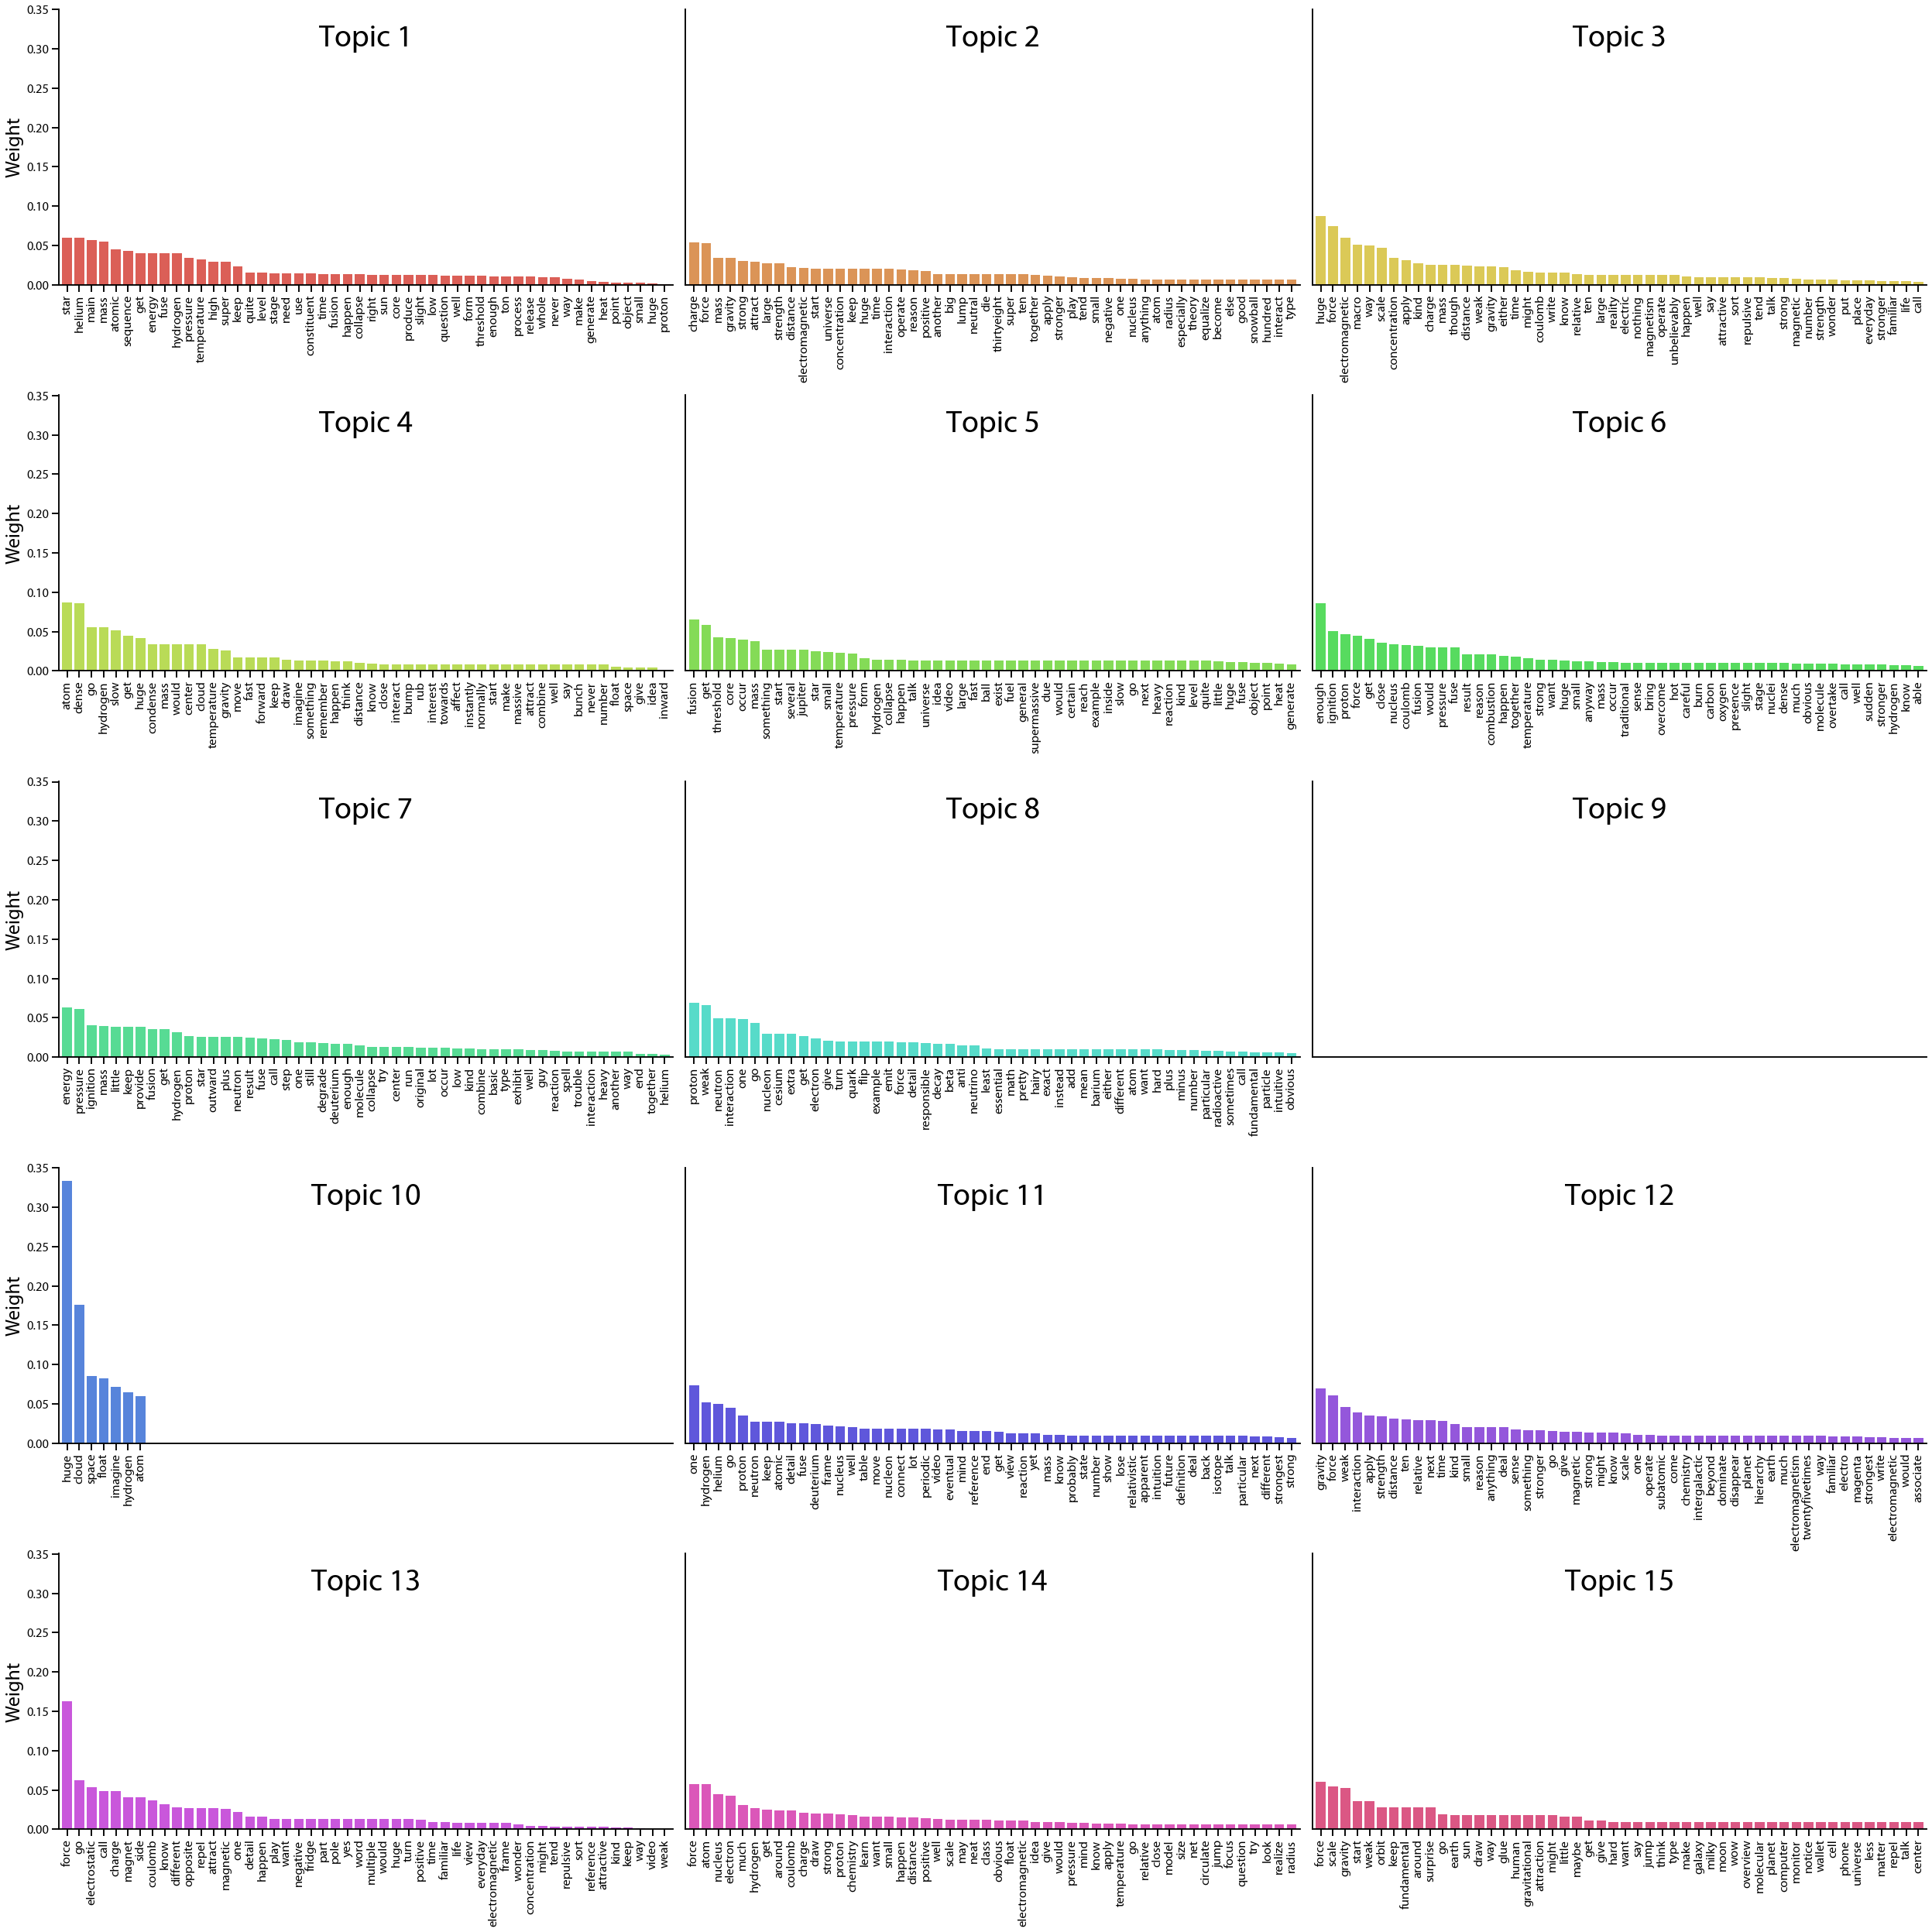

In [7]:
with sns.plotting_context('talk'):    
    fig, axarr = plt.subplots(5, 3, sharey=True, figsize=(35, 35))
    axarr = axarr.flatten()

    palette = sns.color_palette('hls', N_TOPICS)
    
    for topic_ix, ax in enumerate(axarr):
        topic_data = word_weights_df.loc[f"Topic {topic_ix+1}"].T.dropna()
        color = palette[topic_ix]
        ax.bar(range(len(topic_data)), topic_data['weight'], color=color)        
        ax.set_xticks(range(len(topic_data)), labels=topic_data['word'], rotation=90)
        ax.set_xlim(-0.7, N_TOP_WORDS - 0.3)
        ax.set_title(f"Topic {topic_ix + 1}", fontsize=40, y=0.85)
        
        ax.spines[['top', 'right']].set_visible(False)
        
        if topic_ix % 3:
            ax.tick_params(axis='y', length=0)
        else:
            ax.set_ylabel('Weight', fontsize='x-large')
        
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.02, hspace=0.4)
#     plt.savefig(FIG_DIR.joinpath('topic-word-distributions.pdf'), bbox_inches='tight')
    plt.show()